## 1 The cell-state latent space is obtained from single-cell data.

In [2]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd
import scipy

In [3]:
# loading data
data_path = '/home/wtu/su/code/ourmargarter master-3/data-h5ad/lung/PNS.h5ad' # 数据PNS  维度(649, 16122)
datasets_names = 'PNS cells'

adata = sc.read(data_path)
filtered_df = pd.DataFrame(data=adata.to_df())
data = sc.AnnData(filtered_df)
filtered_df.shape  # 维度显示

(649, 16122)

In [4]:
ture_stage = adata.obs['development_stage']
adata.obs['development_stage']

GCGCAGTGTCCAGTTA-5891STDY8062349    18th week post-fertilization human stage
GGATGTTTCTTTACAC-5891STDY8062353    15th week post-fertilization human stage
TGTCCCAGTGGAAAGA-5891STDY8062353    15th week post-fertilization human stage
AAACCTGCACCTCGGA-WSSS8012016                               Carnegie stage 19
ACATCAGAGTCGTACT-WSSS8012016                               Carnegie stage 19
                                                      ...                   
CTGAAGTAGTCAAGCG-5891STDY9030810    11th week post-fertilization human stage
GAATGAAGTATAAACG-5891STDY9030810     9th week post-fertilization human stage
TGGCCAGGTATAGTAG-5891STDY9030810    11th week post-fertilization human stage
TTCTCCTTCATGTCTT-5891STDY9030810    11th week post-fertilization human stage
TTCTTAGGTCGGATCC-5891STDY9030810     9th week post-fertilization human stage
Name: development_stage, Length: 649, dtype: category
Categories (8, object): ['Carnegie stage 16', 'Carnegie stage 19', '9th week post-fertilization hum

In [5]:
ture_stage_number = []
for i in range(len(adata.obs['development_stage'])):
    # OH = int(adata.obs['development_stage'][i][:2])
    if len(adata.obs['development_stage'][i]) == 40:
        OH = int(adata.obs['development_stage'][i][:2])
    elif len(adata.obs['development_stage'][i]) == 39:
        int(adata.obs['development_stage'][i][:1])
    elif len(adata.obs['development_stage'][i]) == 17:
        OH = int(adata.obs['development_stage'][i][15:])
    else:
        OH = 0
    ture_stage_number.append(OH)

ture_stage_number = np.array(ture_stage_number) # ture_stage_number
ture_stage_number

array([18, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [6]:
# # 读取真实标签
# ture_stage = pd.read_csv('/home/wtu/su/code/ourmargarter master-3/data-h5ad/lung/pns_development_stage.txt',delimiter=',')
# ture_stage = ture_stage.stage
# ture_stage

In [7]:
ture_labels = adata.obs['cell_type']
ture_labels

GCGCAGTGTCCAGTTA-5891STDY8062349             Schwann cell
GGATGTTTCTTTACAC-5891STDY8062353             Schwann cell
TGTCCCAGTGGAAAGA-5891STDY8062353             Schwann cell
AAACCTGCACCTCGGA-WSSS8012016        immature Schwann cell
ACATCAGAGTCGTACT-WSSS8012016                       neuron
                                            ...          
CTGAAGTAGTCAAGCG-5891STDY9030810                   neuron
GAATGAAGTATAAACG-5891STDY9030810             Schwann cell
TGGCCAGGTATAGTAG-5891STDY9030810             Schwann cell
TTCTCCTTCATGTCTT-5891STDY9030810             Schwann cell
TTCTTAGGTCGGATCC-5891STDY9030810             Schwann cell
Name: cell_type, Length: 649, dtype: category
Categories (5, object): ['neuron', 'Schwann cell precursor', 'immature Schwann cell', 'Schwann cell', 'neural progenitor cell']

### 1.1 Preliminary processing of PCA

In [8]:
from margaret.utils.util import run_pca
# 效率计算
import time
start1 = time.time()
#应用pca产生初始指标
print('Computing PCA...')
X_pca, va, n_comps = run_pca(data, use_hvg=False, n_components=300)
data.obsm['X_pca'] = X_pca #data: Any = sc.AnnData(filtered_df)
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.381502628326416
Components computed: 300


### 1.2 DFNN is used to extract the features of the data.

In [9]:
import warnings # 警告信息的控制
from margaret.train_metric import train_metric_learner

with warnings.catch_warnings():
    # 过滤掉PyTorch中关于保存调度程序状态的用户警告
    warnings.simplefilter("ignore")
    train_metric_learner(data, n_episodes=5, n_metric_epochs=30, obsm_data_key='X_pca', code_size=5,
        backend='leiden', device='cuda', save_path='./content/metric/news'+datasets_names+'chkpt',
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 50},
        trainer_kwargs={'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 256}
    )
start2 = time.time()

Generating initial clusters
Runtime for determine_cell_clusters(): 5.362525939941406
Training for episode: 1


100%|██████████| 649/649 [00:00<00:00, 4234.81it/s]


Re-generating clusters for episode: 1
Runtime for determine_cell_clusters(): 0.10271763801574707
Time Elapsed for epoch: 5.8882575035095215s
Training for episode: 2


100%|██████████| 649/649 [00:00<00:00, 3740.85it/s]


Re-generating clusters for episode: 2
Runtime for determine_cell_clusters(): 0.10162973403930664
Time Elapsed for epoch: 5.2101781368255615s
Training for episode: 3


100%|██████████| 649/649 [00:00<00:00, 3474.26it/s]


Re-generating clusters for episode: 3
Runtime for determine_cell_clusters(): 0.09581208229064941
Time Elapsed for epoch: 5.270010948181152s
Training for episode: 4


100%|██████████| 649/649 [00:00<00:00, 3539.74it/s]


Re-generating clusters for episode: 4
Runtime for determine_cell_clusters(): 0.14740991592407227
Time Elapsed for epoch: 4.9641876220703125s
Training for episode: 5


100%|██████████| 649/649 [00:00<00:00, 3284.85it/s]


Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 0.08327150344848633
Time Elapsed for epoch: 5.280646800994873s
Runtime for train_metric_learner(): 32.820234537124634


In [10]:
# The cell-state latent space
m_embedding = data.obsm["metric_embedding"]
m_embedding.shape

(649, 5)

In [11]:
# The clustering results obtained at the same time
m_communities = data.obs['metric_clusters'].to_numpy().astype(np.int)

/tmp/ipykernel_517928/3193506688.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m_communities = data.obs['metric_clusters'].to_numpy().astype(np.int)


datasets_shape:  (649, 16122)
umap_embedding_shape: (649, 2)


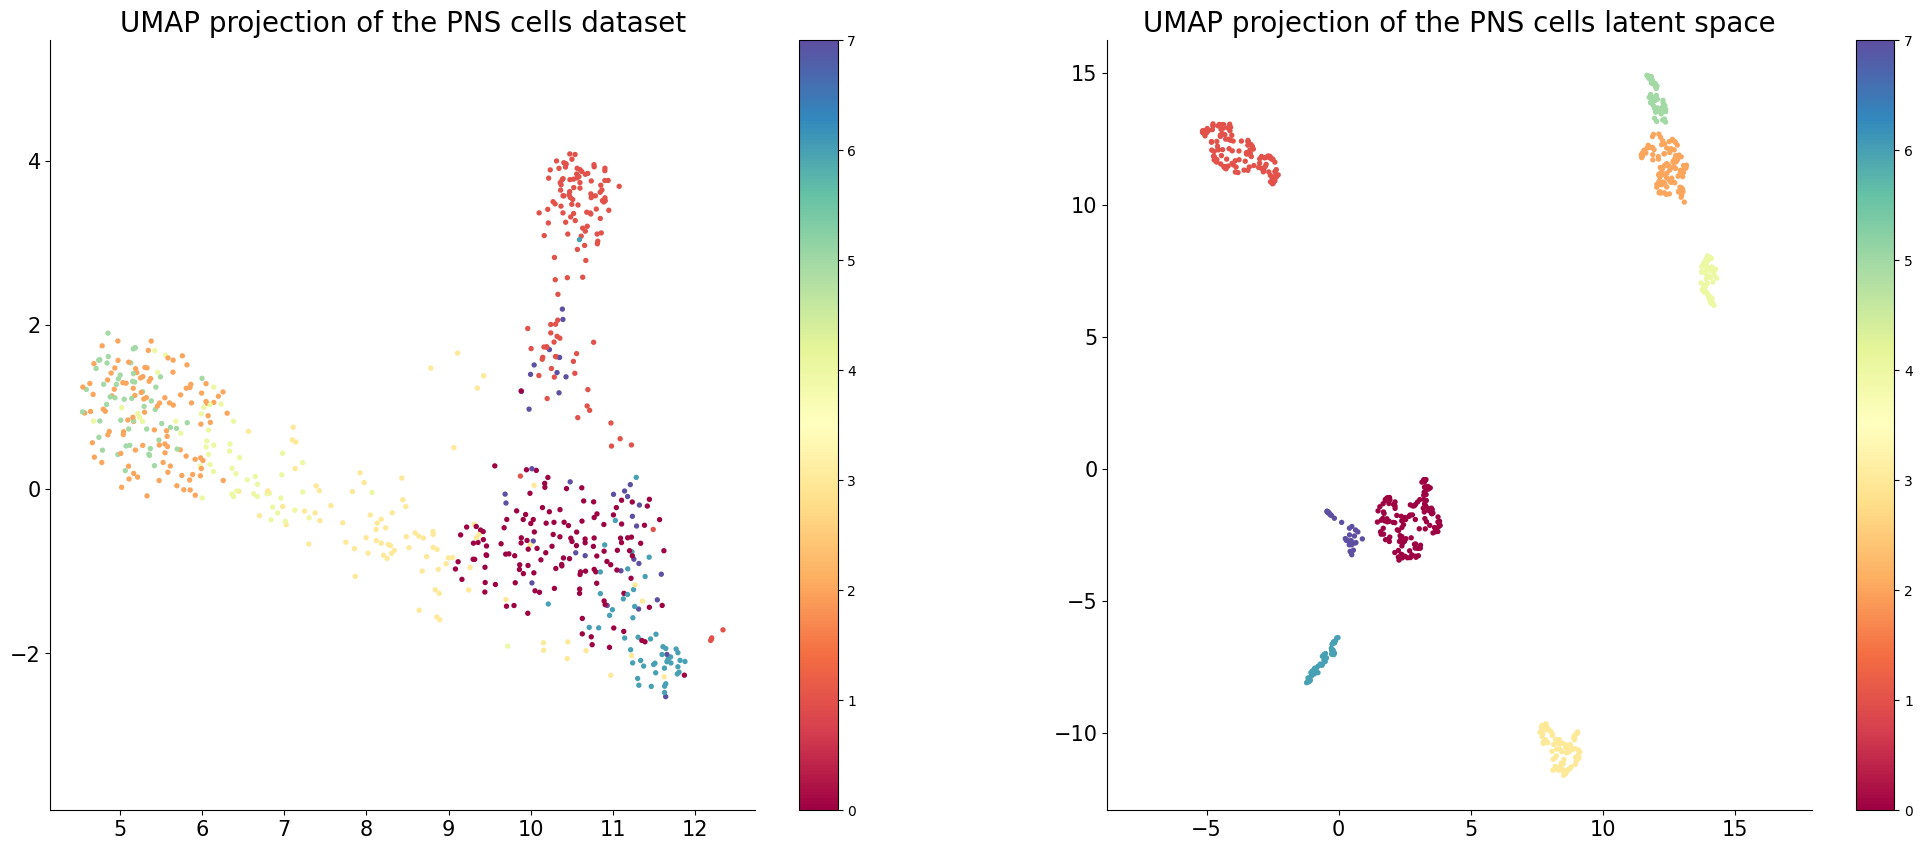

In [98]:
##############################################
# 数据导入
# data = m_embedding
import matplotlib.pyplot as plt
# plt.style.use(["seaborn-darkgrid", "seaborn-colorblind", "seaborn-notebook"])
plt.style.use('default')
datasets = adata.X
print('datasets_shape: ',datasets.shape)

fig1 = plt.figure(figsize=(25,10))

import umap
import matplotlib.pyplot as plt
# the original data space
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(datasets)
print('umap_embedding_shape:',umap_embedding.shape)
plt.subplot(121)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=m_communities, cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.title('UMAP projection of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# the cell-state latent space
embedding = reducer.fit_transform(m_embedding)

plt.subplot(122)
plt.scatter(embedding[:, 0], embedding[:, 1], c=m_communities, cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(6))
plt.colorbar()
plt.title('UMAP projection of the '+datasets_names+' latent space',fontdict={'weight':'normal','size': 20})


plt.savefig("./result/figure/3"+datasets_names+"_01latent spatial visualization.png")  #保存图片
plt.savefig("./result/pdf/3"+datasets_names+"_01latent spatial visualization.pdf")  #保存图片
plt.show()

## 2 Trajectory modeling is based on stochastic probability model.

In [93]:

import time
from DTFLOW import *
start3 = time.time()

z = DTFLOW(m_embedding,m_communities)

M = z.get_transition_matrix(10)
S = z.get_diffusionRWR(p=0.9)
Y = z.get_Y(slover='SVD',dim=2)
print('The dimension of Y :', Y.shape)
end1 = time.time()
print(datasets_names+'our代码运行日期',time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 
print (datasets_names+'训练时间和DTFLOW运行总时间：',str(end1-start3+start2-start1))  
print (datasets_names+'our_dtflow运行时间：',str(end1-start3))  # 记录时间点1

The dimension of Y : (649, 2)
PNS cellsour代码运行日期 2023-07-10 16:52:06
PNS cells训练时间和DTFLOW运行总时间： 34.259392976760864
PNS cellsour_dtflow运行时间： 0.12057042121887207


### 2.1 Trajectory visualization is based on the real stage

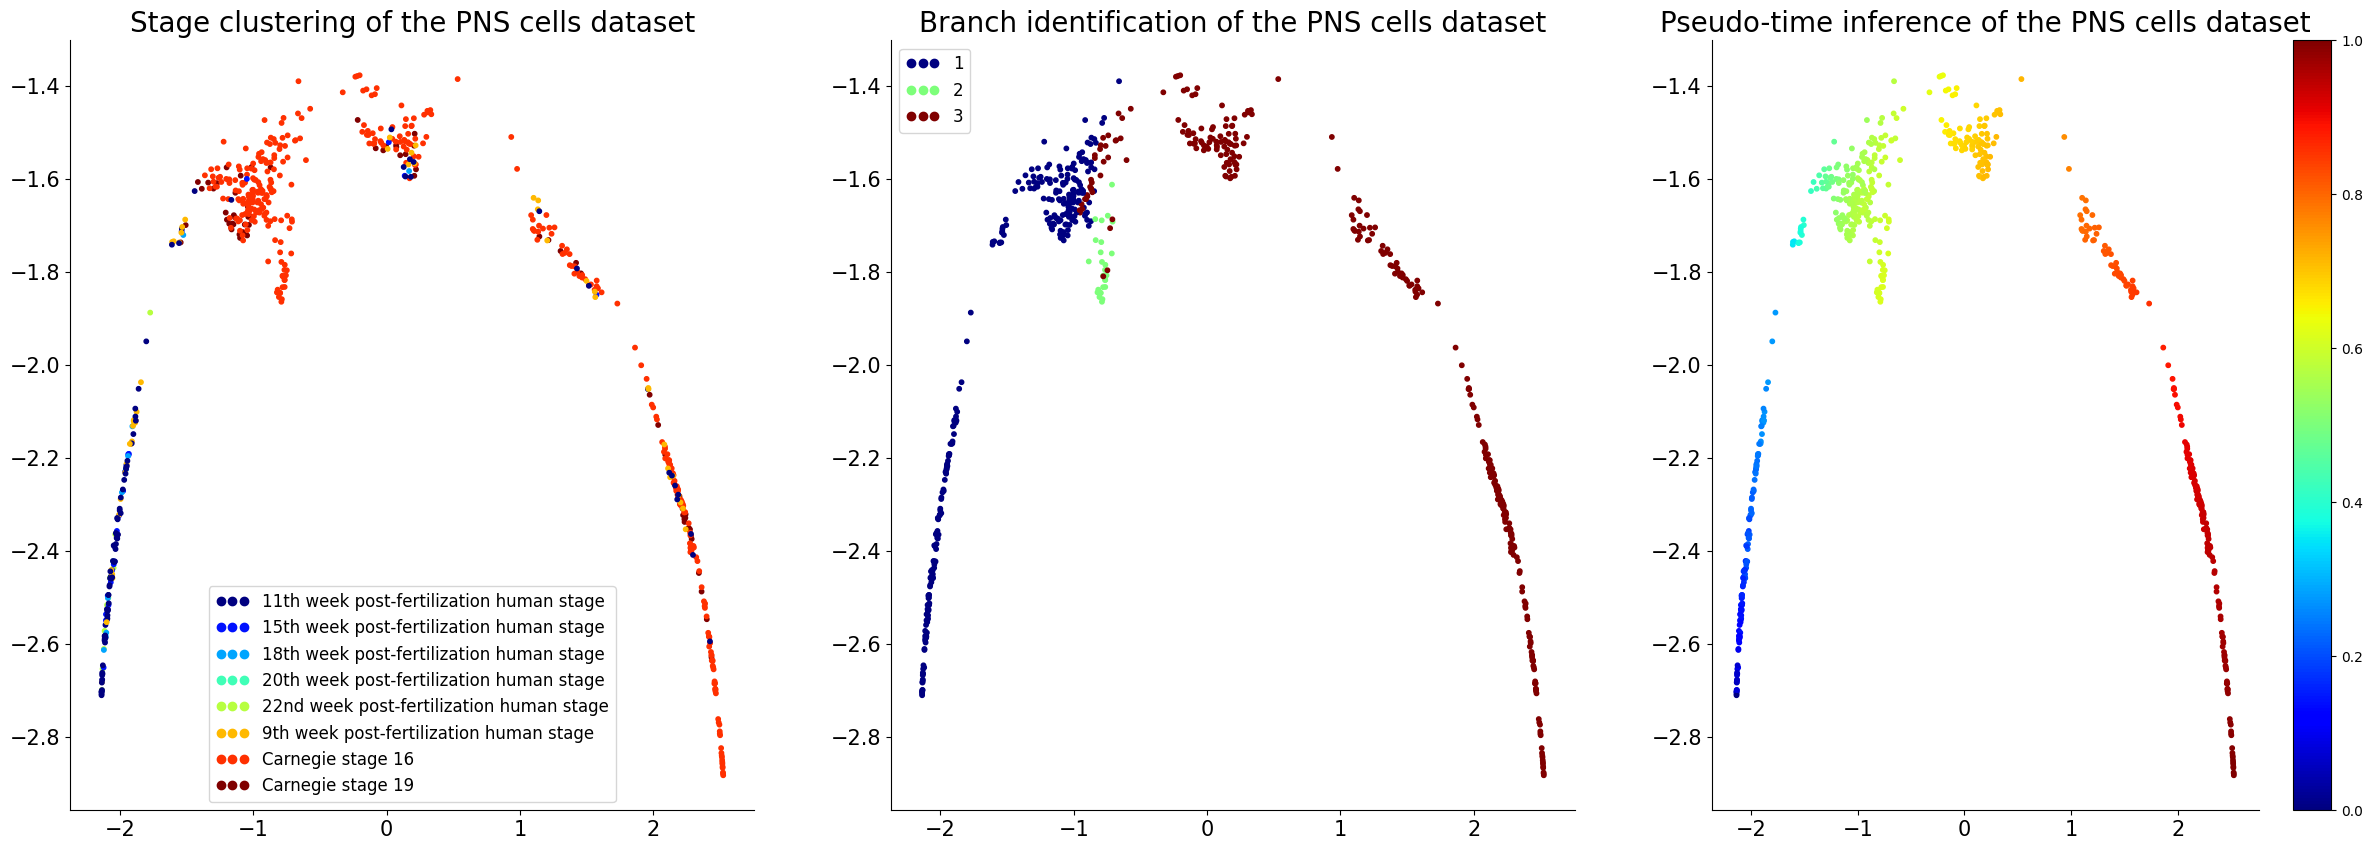

In [94]:
dims=[0,1]
# plt.style.use('default')
fig = plt.figure(figsize=(30,10))
stages = ture_stage
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors1 = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
# ax = plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors1,s=8)
plt.legend(markers, color_dict.keys(), loc='best', numpoints=3,fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.gca().set_axis_off()
# plt.grid(False)

plt.title('Stage clustering of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# 计算伪时间
# print('stages:',stages)
root_list = list(np.where(stages == '11th week post-fertilization human stage')[0])   # 对应标签中的起始阶段
# print('root_list',root_list)
dftimes_ml = z.get_dtflow_times(root_list)
np.savetxt("./result/execl/3"+datasets_names+"_01mlbkfd pseudotime.csv",dftimes_ml,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = z.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 

# 子图3，4
plt.subplot(133) 
p = plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c= dftimes_ml, s=8, cmap='jet')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(p)

plt.title('Pseudo-time inference of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors,s=8)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
plt.title('Branch identification of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})
# plt.savefig('./figures/1'+datasets_names+' dataset/1')   #保存图片
plt.savefig("./result/figure/3"+datasets_names+"_02_MLBKFD_based on the real stage.png")
plt.savefig("./result/pdf/3"+datasets_names+"_02_MLBKFD_based on the real stage.pdf")
plt.show()

### 2.2 Trajectory visualization is based on this method stage

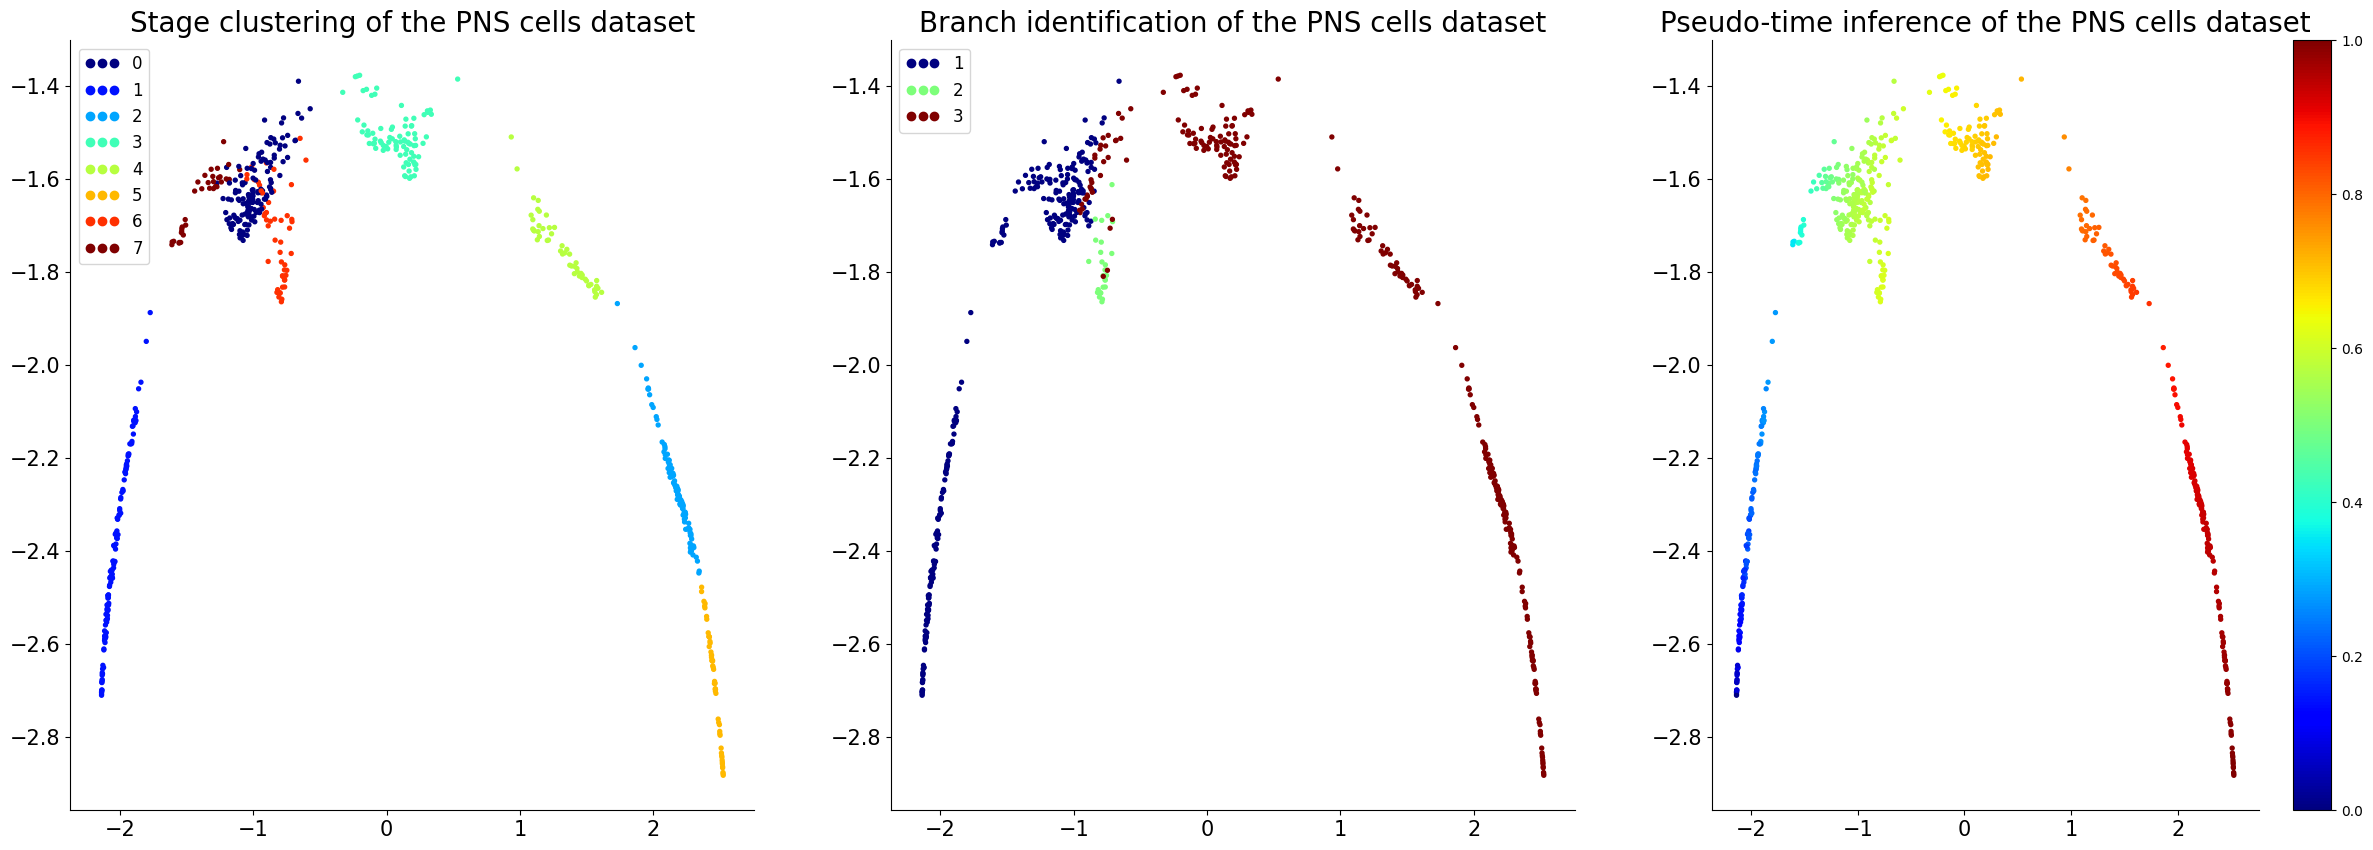

In [100]:
dims=[0,1]
fig = plt.figure(figsize=(30,10))


stages = m_communities
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors1 = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors1,s=8)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Stage clustering of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# 计算伪时间
root_list = list(np.where(m_communities == 1)[0])
dftimes = z.get_dtflow_times(root_list)
np.savetxt("./result/execl/3"+datasets_names+"_02mlbkfd0 pseudotime.csv",dftimes,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = z.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 
# 子图3，4
plt.subplot(133) 
p = plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c= dftimes, s=8, cmap='jet')
plt.colorbar(p)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Pseudo-time inference of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors,s=8)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Branch identification of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})
# plt.savefig('./figures/1'+datasets_names+' dataset/1')   #保存图片
plt.savefig("./result/figure/"+datasets_names+"_03Trajectory visualization is based on this method stage.png")
plt.savefig("./result/pdf/"+datasets_names+"_03Trajectory visualization is based on this method stage.pdf")
plt.show()

##  3 真标签出图

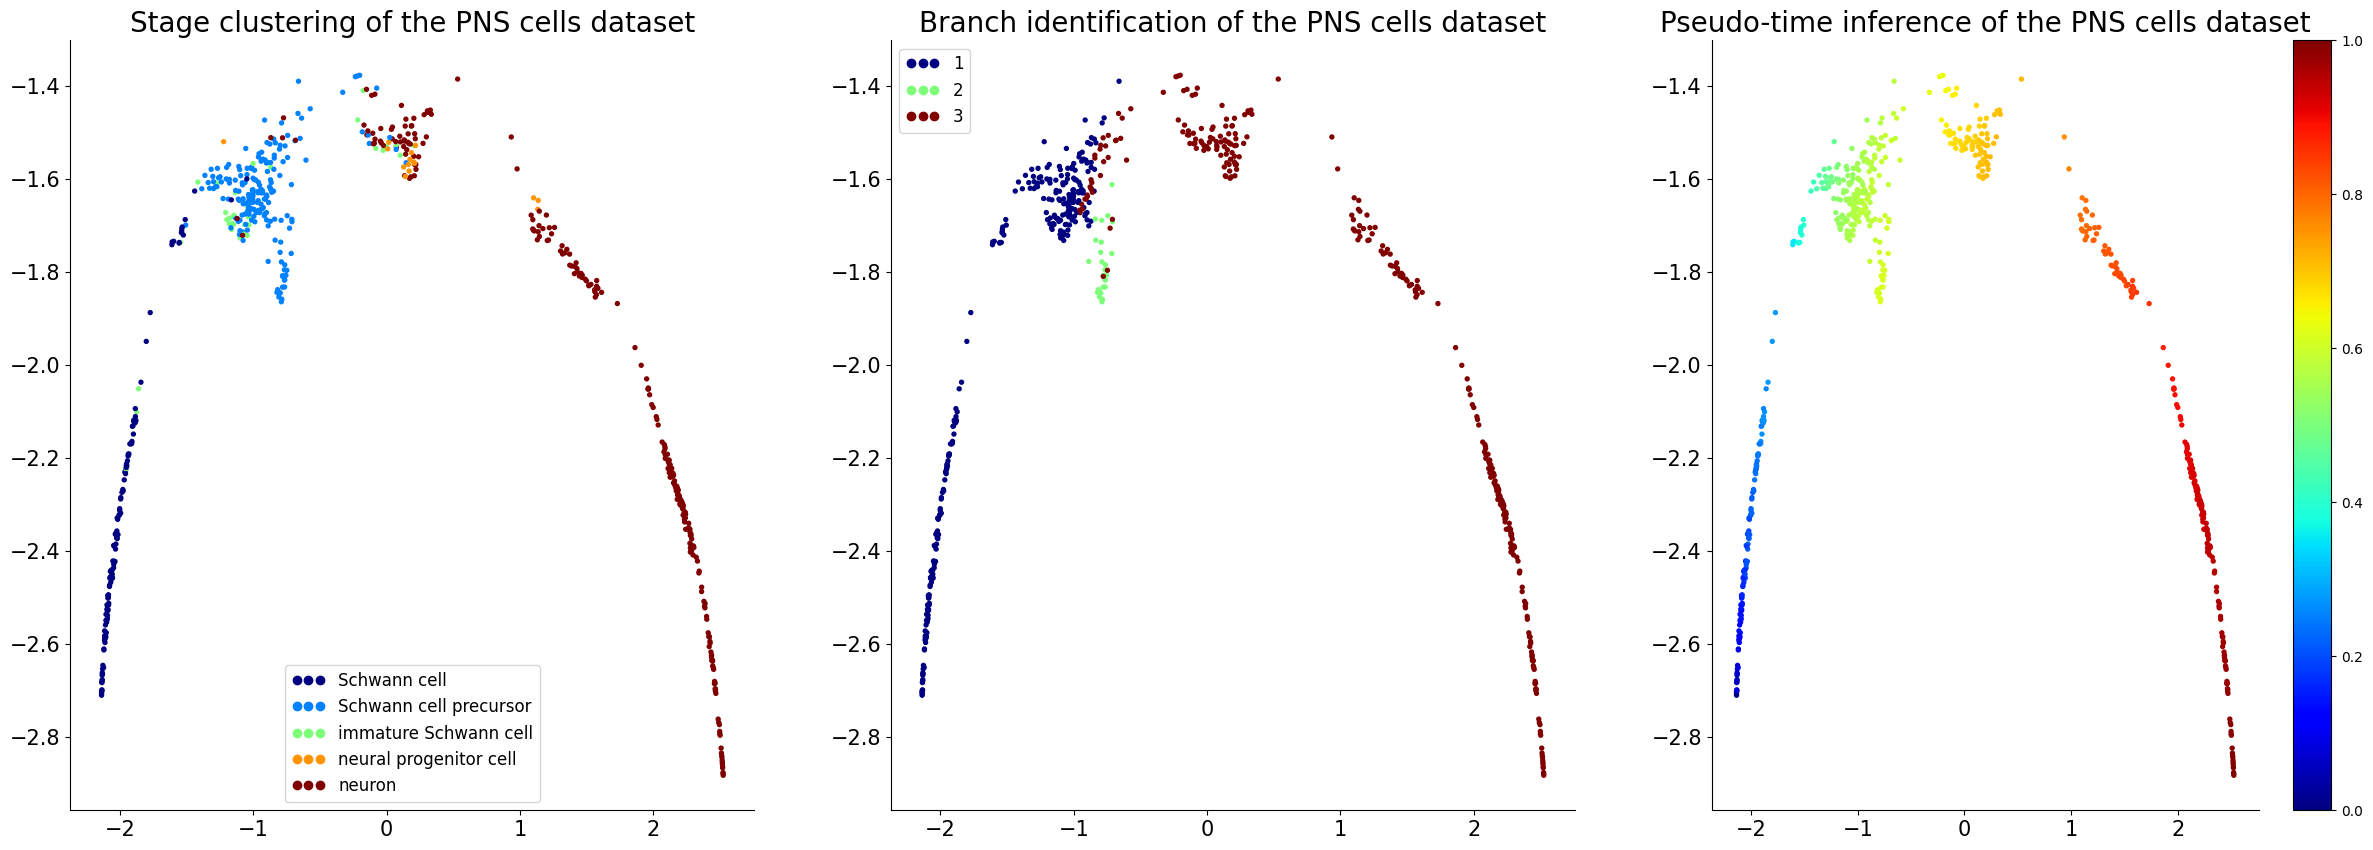

In [102]:
dims=[0,1]
fig = plt.figure(figsize=(30,10))

stages = ture_labels
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors1 = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors1,s=8)
plt.legend(markers, color_dict.keys(), loc='best', numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Stage clustering of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# 计算伪时间
root_list = list(np.where(m_communities == 1)[0])
dftimes = z.get_dtflow_times(root_list)

# 计算分支
branch = z.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 

# 子图3，4
plt.subplot(133) 
p = plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c= dftimes, s=8, cmap='jet')
plt.colorbar(p)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Pseudo-time inference of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors,s=8)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Branch identification of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})
# plt.savefig('./figures/1'+datasets_names+' dataset/1')   #保存图片
plt.savefig("./result/figure/"+datasets_names+"_0301.png")
plt.savefig("./result/pdf/"+datasets_names+"_0301.pdf")
plt.show()

## 纯DTFLOW计算的时间

In [103]:
import scipy as sp
import sys

time_stages = ture_stage
# timeture_stages =np.loadtxt('pns_development_stage.txt',dtype=np.float32)

raw_df = adata.X

cell_names = data.obs
gene_names = data.var

raw_df.shape

# 计算效率计算
import time
start_d1 = time.time()
, fontsize="large"
# 
dz = DTFLOW(raw_df,time_stages)
dz = DTFLOW(raw_df,time_stages)
dM = dz.get_transition_matrix(10)
dS = dz.get_diffusionRWR(p=0.9)

dY = dz.get_Y(slover='SVD',dim=2)
# z.plotY(size=(10,10),dims=[0,1],color ='stages')

# DTFLOW部分
end2 = time.time()

print (datasets_names+'dtflow运行时间：',str(end2-start_d1))  #记录点2 

PNS cellsdtflow运行时间： 0.5878300666809082


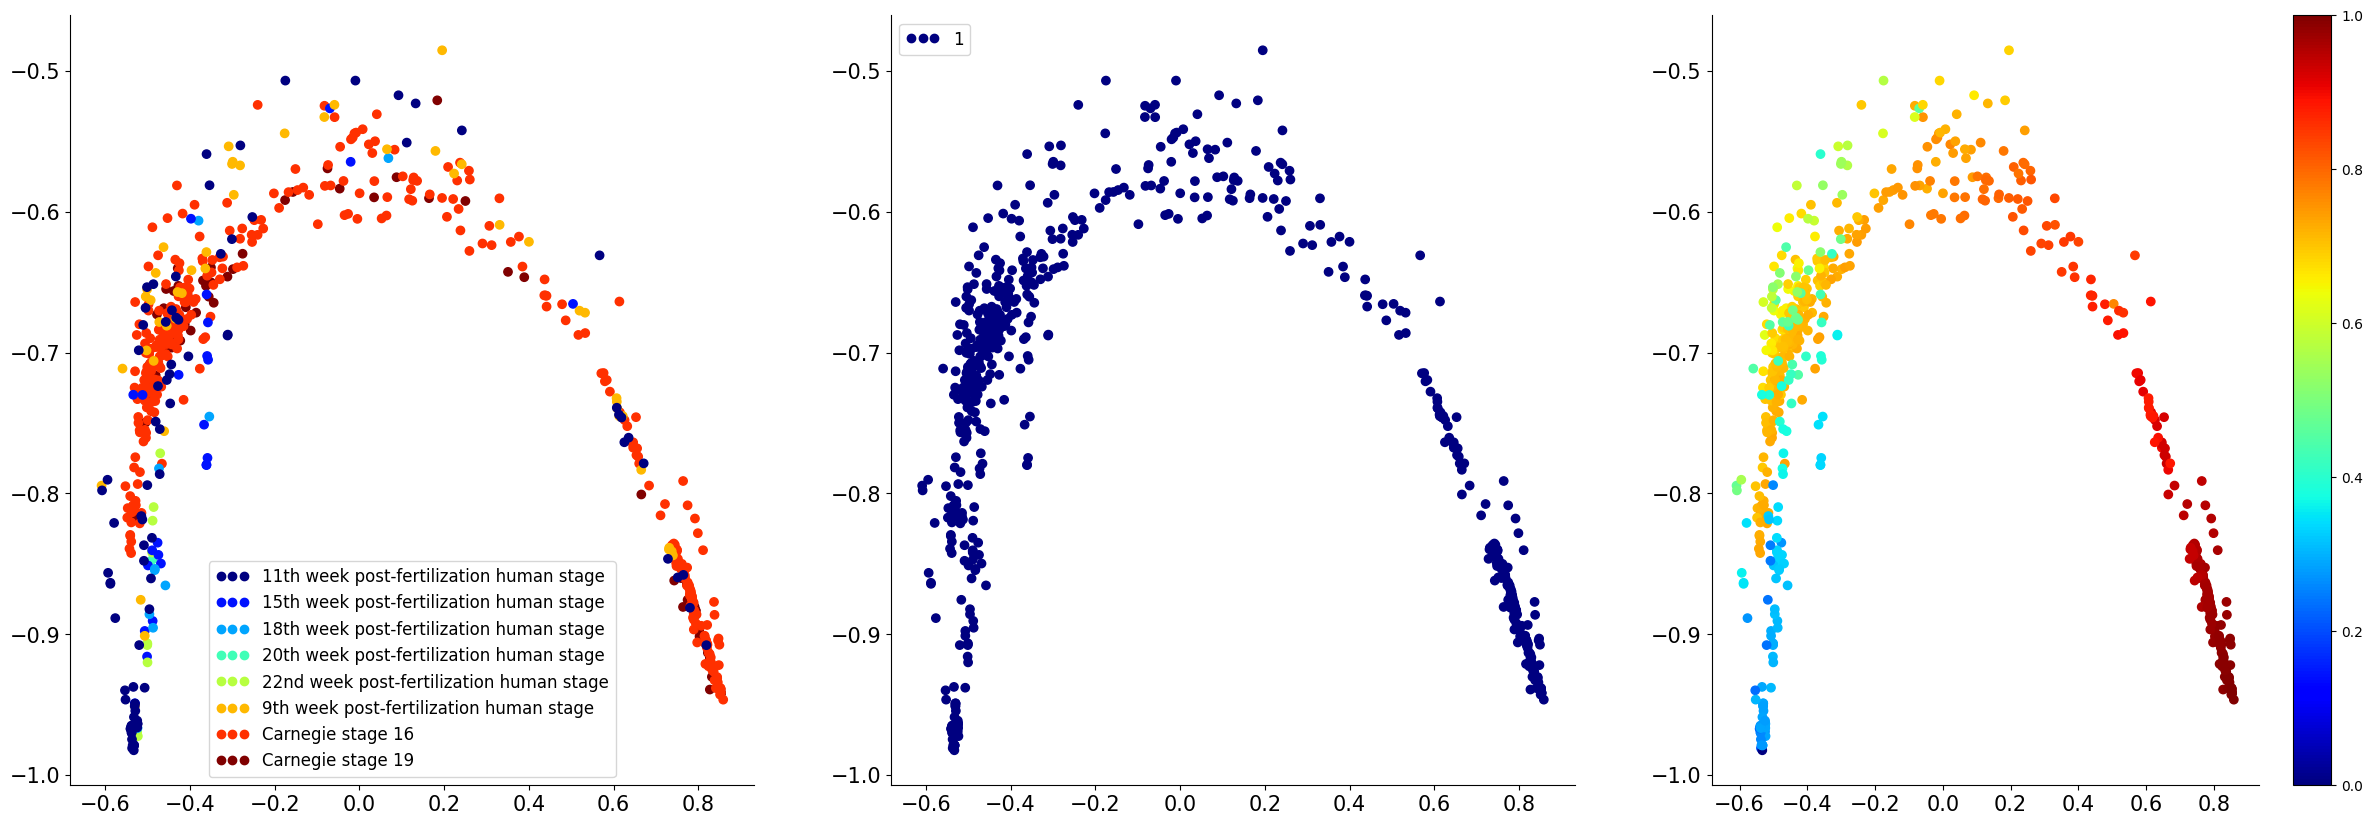

In [105]:
dims=[0,1]
fig = plt.figure(figsize=(30,10))
# 子图1，2
# plt.subplot(141) 
# plt.scatter(dY[:,dims[0]],dY[:,dims[1]])


stages = ture_stage
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c=sc_colors)
plt.legend(markers, color_dict.keys(), loc='best', numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# 计算伪时间
root_list = list(np.where(stages == '11th week post-fertilization human stage')[0])
dtflowtimes1 = dz.get_dtflow_times(root_list)
np.savetxt("./result/execl/3"+datasets_names+"_03DTFLOW pseudotime.csv",dtflowtimes1,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = dz.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 

# 子图3，4
plt.subplot(133) 
p = plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c= dtflowtimes1, cmap='jet')
plt.colorbar(p)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c=sc_colors)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("./result/figure/"+datasets_names+"_04DTFLOW.png")  #保存图片
plt.savefig("./result/pdf/"+datasets_names+"_04DTFLOW.pdf")  #保存图片
plt.show()

In [106]:
import scipy.stats

# Create two lists of random values
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# y = [2, 1, 2, 4.5, 7, 6.5, 6, 9, 9.5]
x = dftimes_ml
y = dftimes
z = dtflowtimes1
ture_labels = ture_stage_number
print('Spearman rank correlation coefficient of '+datasets_names+'\n'+'ture_labels=stage'+'\n')
print(scipy.stats.pearsonr(ture_labels, x)[0])
print(scipy.stats.pearsonr(ture_labels, y)[0])
print(scipy.stats.pearsonr(ture_labels, z)[0])
# 0.9412443251336238
print(scipy.stats.spearmanr(ture_labels, x)[0])
print(scipy.stats.spearmanr(ture_labels, y)[0])
print(scipy.stats.spearmanr(ture_labels, z)[0])  # 记录点3

Spearman rank correlation coefficient of PNS cells
ture_labels=stage

0.3164219359565521
0.3164219359565521
0.35737510447784326
0.27769452674891393
0.27769452674891393
0.3423236465596695
